# A time-dependent problem, Burgers' equation

We will solve the viscous Burgers equation, a nonlinear equation for the advection and diffusion on momentum in one dimension:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0.
$$

We will solve on a periodic interval mesh, and therefore do not impose any boundary conditions.  As usual, we need to derive a variational form.

## Spatial discretisation

We first discretise in space, mulitplying by a test function $v \in V$ and integrating the viscosity term by parts to obtain the semi-discrete problem. Find $u(x, t) \in V$ such that

$$
\int_\Omega \frac{\partial u}{\partial t} v + u \frac{\partial u}{\partial x} v + \nu \frac{\partial u}{\partial x}\frac{\partial v}{\partial x} \, \mathrm{d}x = 0 \quad \forall v \in V.
$$

## Time discretisation
We now need to discretise in time.  For simplicity, and stability we'll use backward Euler, replacing all instances of $u$ with $u^{n+1}$ and the time derivative by $\frac{u^{n+1} - u^n}{\Delta t}$.  We end up with the discrete problem, find $u^{n+1} \in V$ such that

$$
\int_\Omega \frac{u^{n+1} - u^n}{\Delta t} v + u^{n+1} \frac{\partial u^{n+1}}{\partial x} v + \nu \frac{\partial u^{n+1}}{\partial x}\frac{\partial v}{\partial x} \, \mathrm{d}x = 0 \quad \forall v \in V.
$$



## Implementation

To solve the problem in a concrete setting, we need two things: a domain, and an initial condition for $u$.  For the former, we'll choose a periodic interval of length 2, for the latter, we'll start with $u = \sin(2 \pi x)$.

In addition we need to choose the viscosity, which we will set to a small constant value $\nu = 10^{-2}$.

As ever, we begin by importing Firedrake:

In [1]:
%matplotlib inline
from firedrake import *
from numpy import linspace

n = 100
mesh = PeriodicIntervalMesh(n, length=2)

x = SpatialCoordinate(mesh)[0]

u_init = sin(2*pi*x)

In [2]:
nu = Constant(1e-2, domain=mesh)

We choose degree 2 piecewise continuous Lagrange polynomials for our solution and test space:

In [3]:
V = FunctionSpace(mesh, "Lagrange", 2)

We also need solution functions for $u^{n+1}$ and $u^n$, along with a test function $v$.

In [4]:
u_n1 = Function(V, name="u^{n+1}")
u_n = Function(V, name="u^{n}")
v = TestFunction(V)

We provide the initial condition for $u_n$, and choose a $\Delta t$ such that the advective Courant number is around 1.  This is more restrictive than required for stability of the time integration, but gives us enough accuracy to see the temporal evolution of the system.

In [5]:
u_n.interpolate(u_init)
dt = 1.0 / n

Now we're ready to define the variational form.  Since this problem is nonlinear, note that we do not have a trial function anywhere.  We just write down the residual, Firedrake will automatically compute the Jacobian by differentiating the residual inside the nonlinear solver.

In [6]:
F = (((u_n1 - u_n)/dt) * v +
     u_n1 * u_n1.dx(0) * v + 
     nu*u_n1.dx(0)*v.dx(0))*dx

For visualisation purposes, we will save a copy of the state $u_n$ at each timestep, we can plot and animate these in the notebook if the `ipywidgets` package is installed.

In [7]:
# If passed an existing Function object, the Function 
# constructor makes a copy.
results = [Function(u_n)]

Finally, we loop over the timesteps, solving the equation and advancing in time. We use `firedrake.ProgressBar` to provide a visual indication of the progress of the simulation.


In [8]:
t_end=0.5
for t in ProgressBar("Time step").iter(linspace(0.0, t_end, int(t_end/dt))):
    solve(F == 0, u_n1)
    u_n.assign(u_n1)
    results.append(Function(u_n))

Time step ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 50/50 [0:00:01]


To visualize the results, we'll create a movie using matplotlib's animation tools.
First, we'll create a figure and axes to draw on and plot the initial values.

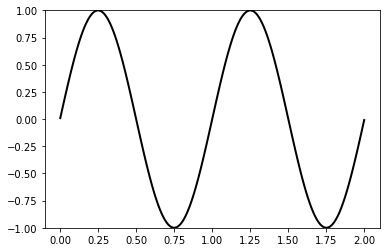

In [9]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_ylim((-1., 1.))
plot(results[0], axes=axes)

Next, we'll create a function that tells matplotlib how to draw each frame of the animation, which in our case will just be plotting the value at that timestep.
The `FuncAnimation` function will call this on the list of results that we pass in, together with a given interval in milliseconds between each frame.
Finally, we'll use the IPython API to render the animation in the notebook.

In [10]:
# NBVAL_IGNORE_OUTPUT
from matplotlib.animation import FuncAnimation

def animate(u):
    axes.clear()
    plot(u, axes=axes)
    axes.set_ylim((-1., 1.))

interval = 4e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())

## A faster implementation

Although the code we wrote above works fine, it can be quite slow.  In particular, each call to `solve` necessitates rederiving the symbolic Jacobian, building new matrices and vectors and solver objects, using them once, and then destroying them.  To avoid this, we can create a solver object and reuse it.

This is what the `solve` call does internally, only it then immediately discards all of this work.

We start by creating a `NonlinearVariationalProblem` which gathers the information about the problem.  The residual, the solution variable, any boundary conditions, and so forth.

In [11]:
problem = NonlinearVariationalProblem(F, u_n1)

Now we create a `NonlinearVariationalSolver`.  Here we provide the problem to be solved, and any options to the solver.

Note that the default solver options simply apply a full LU factorisation as a preconditioner. In one dimension, this produces no fill and is, obviously, an exact solve.

In [12]:
solver = NonlinearVariationalSolver(problem)

Now we just write the time loop as before, but instead of writing `solve(F == 0, u_n1)`, we just call the `solve` method on our `solver` object.

In [13]:
t = 0
t_end = 0.5
while t <= t_end:
    solver.solve()
    u_n.assign(u_n1)
    t += dt

## Exercise 1

Compare the speed of the two implementation choices on a mesh with 1000 elements.

- Hint: You can use the "notebook magic" `%%timeit` to time the execution of a notebook cell.

## Exercise 2

Implement Crank-Nicolson timestepping instead of backward Euler.

- Hint 1: The Crank-Nicolson scheme writes:

   $$\frac{\partial u}{\partial t} + G(u) = 0$$

  as

  $$ \frac{u^{n+1} - u^n}{\Delta t} + \frac{1}{2}\left[G(u^{n+1}) + G(u^n)\right] = 0$$


- Hint 2: It might be convenient to write a python function that returns $G(u)$ given a $u$.